# 0.0 Imports

In [2]:
import inflection
import math
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import xgboost as xgb
import pickle
import warnings

from boruta import BorutaPy
from scipy import stats as ss
from matplotlib import pyplot as plt
from IPython.display import Image

from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [1]:
warnings.filterwarnings("ignore", category=FutureWarning)


## 0.1. Helper Functions

In [3]:
def ts_cross_validation(x_training, model, model_name, k_splits, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    tscv = TimeSeriesSplit(n_splits=k_splits)

    for train_index, validation_index in tscv.split(x_training):
        if verbose:
            print('\nKFold Iteration')

        training, validation = x_training.iloc[train_index], x_training.iloc[validation_index]

        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        m = model.fit(xtraining, ytraining)

        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame({'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat) )

    return pd.DataFrame({'Model Name': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0])

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


# 1.0 Descrição dos Dados


In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new


## 1.2. Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])



## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
#competition_distance  
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)  

#competition_open_since_month  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week   
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year     
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval 
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace= True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


## 1.6. Change Data Types

In [11]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )


### 1.7.1 Numerical Attributes

In [13]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']

### 1.7.2 Categorical Attributes

In [14]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

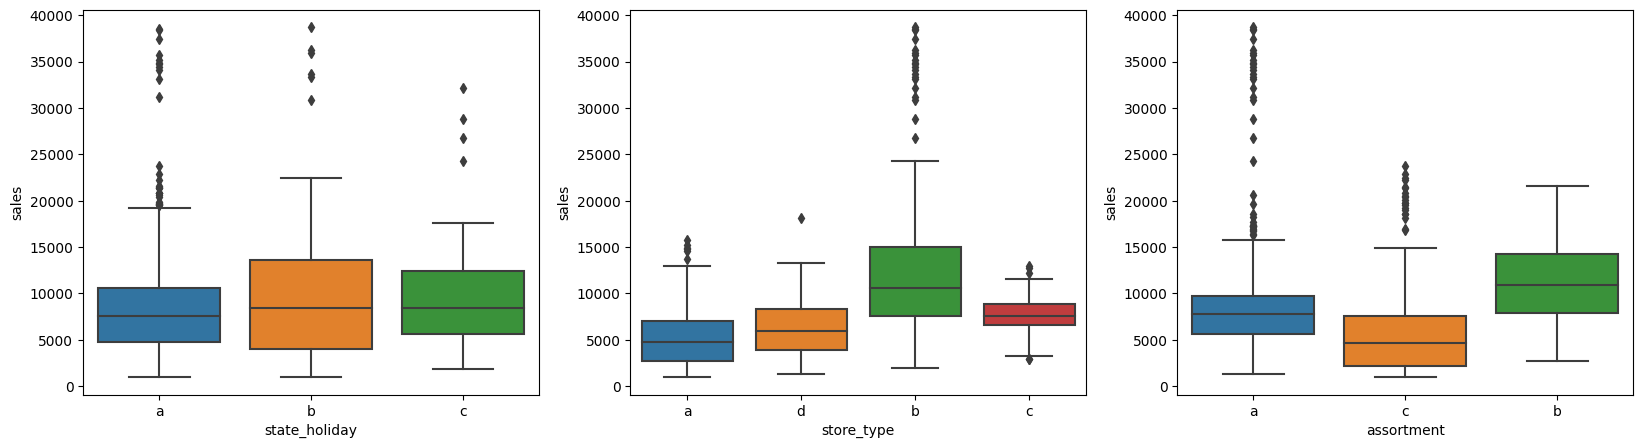

In [15]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.figure(figsize=(20,5))
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )


# 2.0 Passo 02 - Feature Engineering

In [16]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

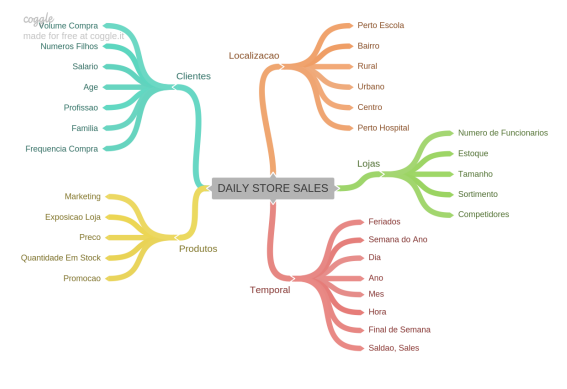

In [17]:
Image('img/MindMapHypothesis.png')

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses Loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais

### 2.2.2 Hipóteses Produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.


### 2.2.3 Hipóteses Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

1. Lojas com maior sortimentos deveriam vender em média mais.
2. Lojas com competidores mais próximos deveriam vender em média menos.
3. Lojas com competidores mais recentes deveriam vendem em média menos.
4. Lojas que aderiram a estratégia de promo2 há mais tempo deveria vender em média menos.
5. Lojas com mais promoções consecutivas deveriam vender em média mais.
6. Lojas abertas durante o feriado de Natal deveriam vender em média mais.
7. Lojas deveriam vender mais ao longo dos anos.
8. Lojas deveriam vender mais no segundo semestre do ano.
9. Lojas deveriam vender em média menos depois do dia 10 de cada mês
10. Lojas deveriam vender em média menos aos finais de semana.
11. Lojas deveriam vender em média menos durante os feriados escolares.

## 2.4 Feature Engineering

In [18]:
# year 
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis = 1)

df2['competition_time_month'] = ( (df2['date'] - df2['competition_since'] )/30).apply(lambda x: x.days).astype(int)

# promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holyday' if x=='a' else 'easter_holyday' if x=='b' else 'christmas' if x == 'c' else 'regular_day')


# 3.0 Passo 03 - Filtragem de Variáveis

In [19]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [20]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [21]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [22]:
df4 = df3.copy()

# 4.0 Passo 04 - Analise Exploratoria dos Dados

## 4.1. Analise Univariada

###  4.1.1. Response Variable

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


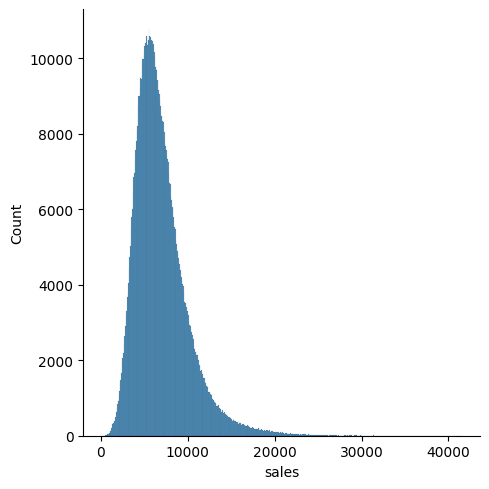

In [23]:
sns.displot( df4['sales'], kde=False )

###  4.1.2. Numerical Variable

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

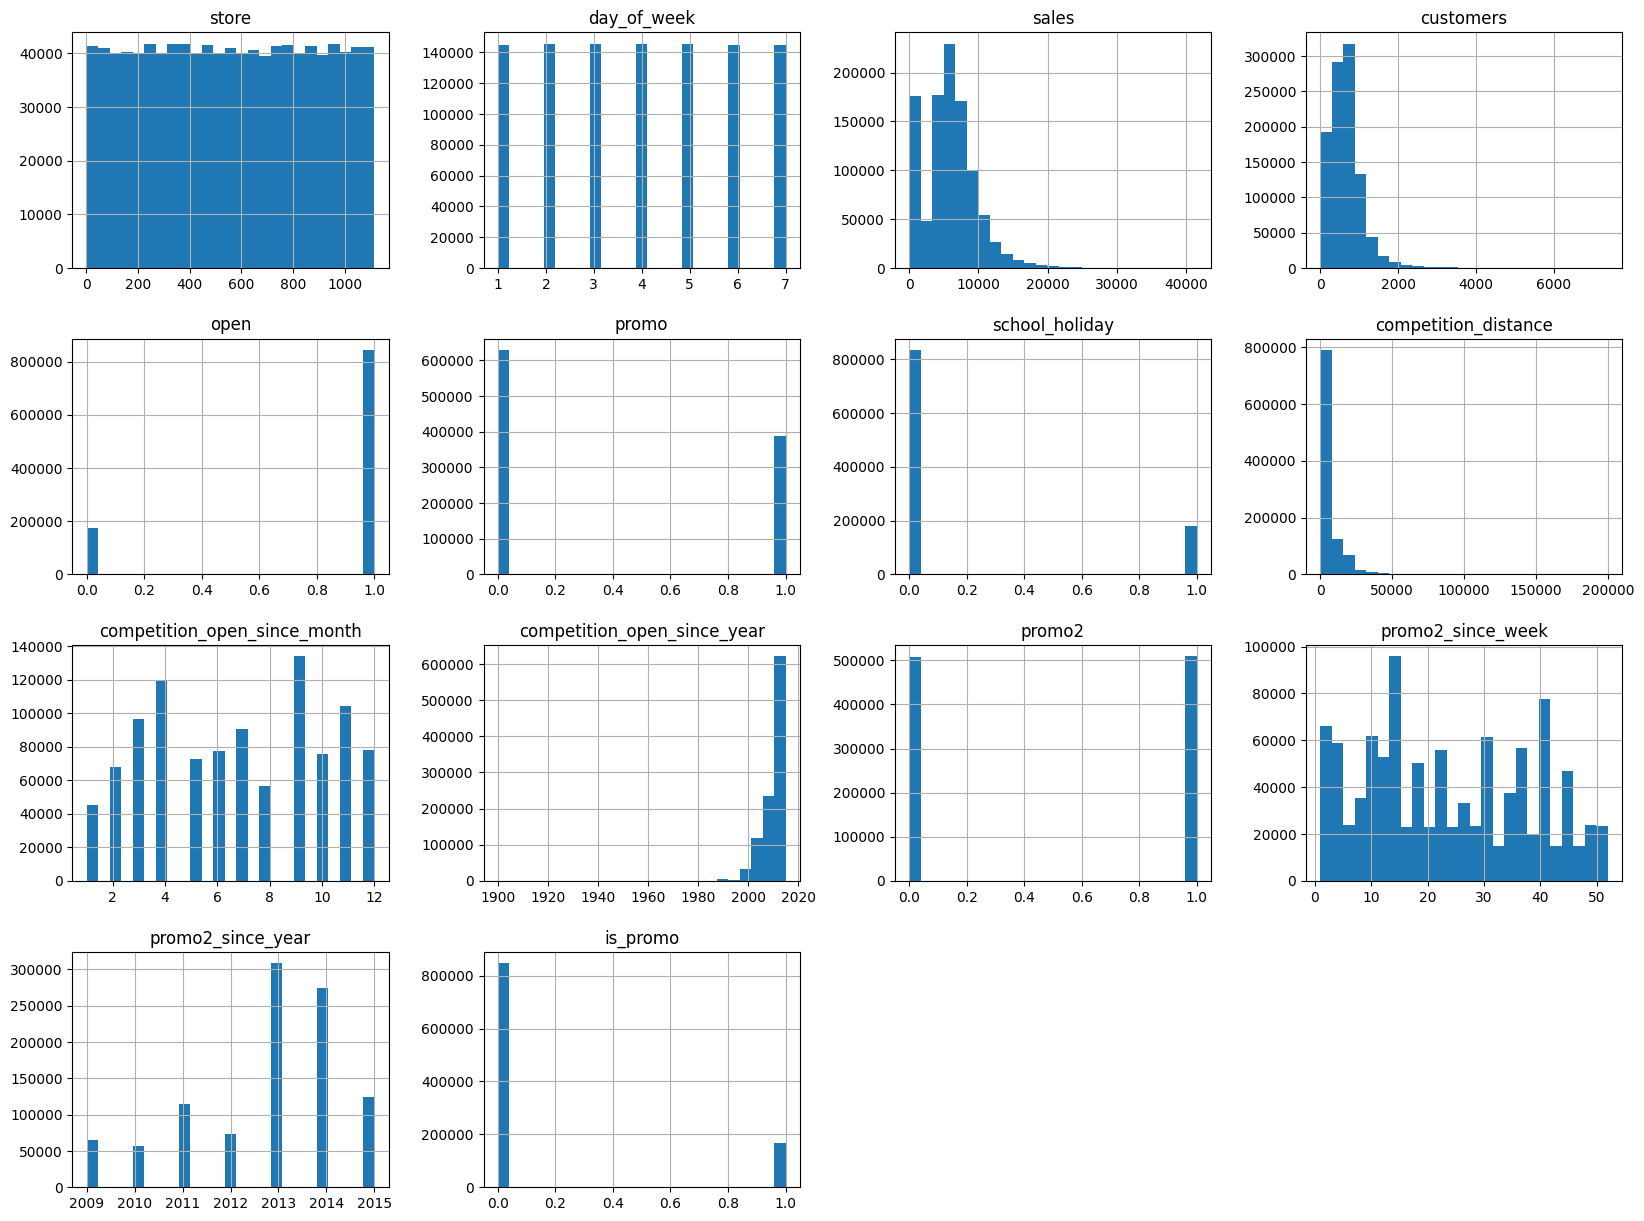

In [24]:
num_attributes.hist(bins = 25, figsize= (20,15))

###  4.1.3. Categorical Variable

<Axes: xlabel='sales', ylabel='Density'>

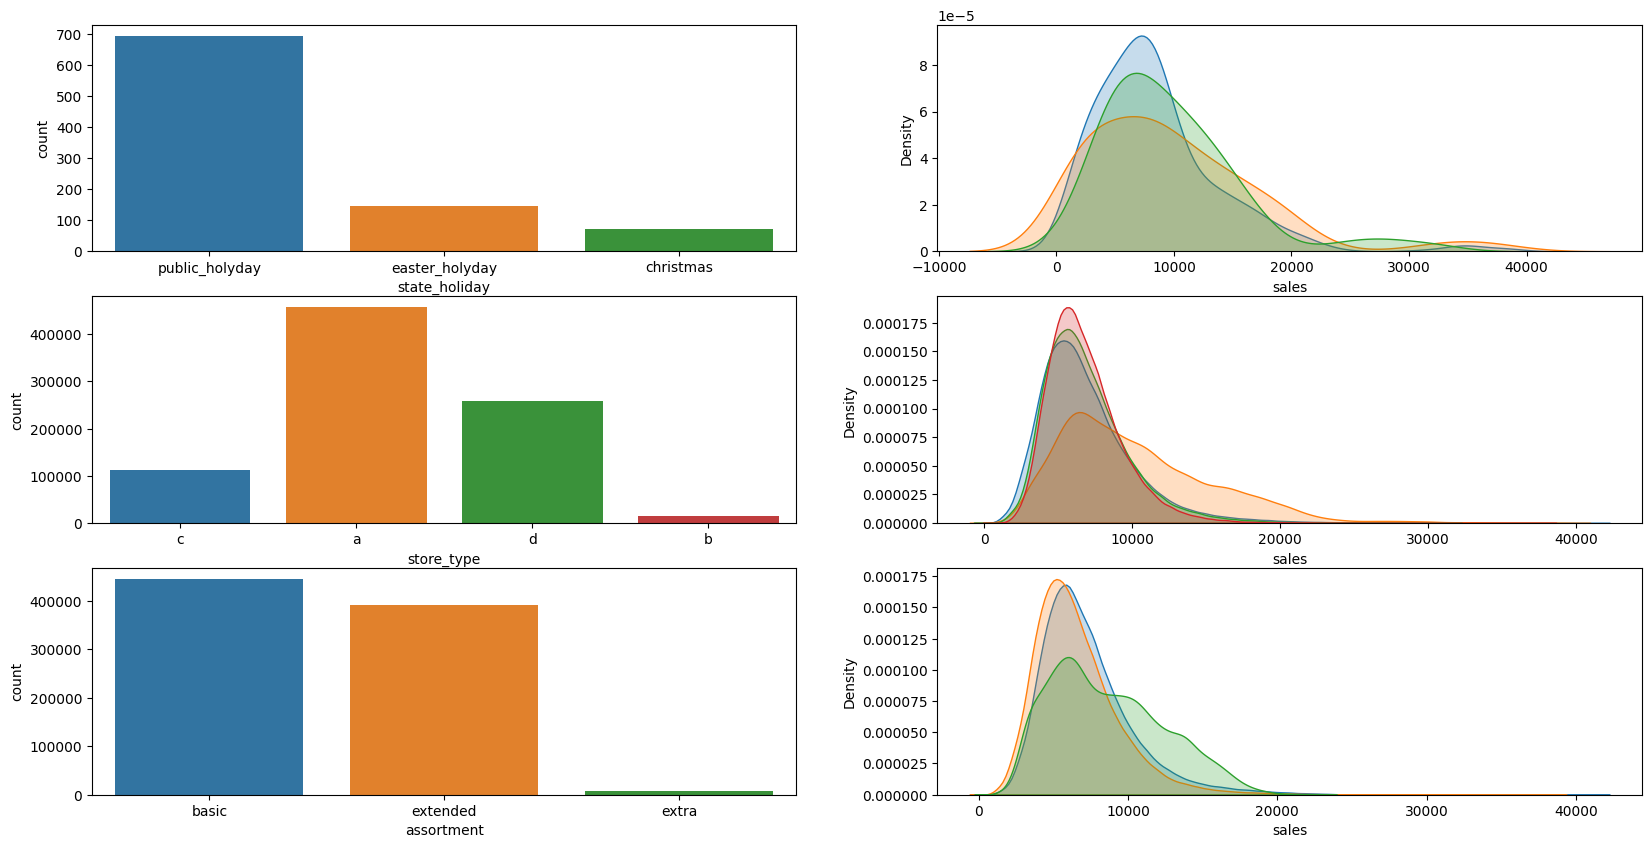

In [25]:
plt.figure(figsize=(20,10))
# state holiday
plt.subplot( 3, 2, 1 )
a = df4.loc[df4['state_holiday'] != 'regular_day', :]
sns.countplot( data= a, x= a['state_holiday'] )


plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holyday']['sales'],label='public_holyday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holyday']['sales'],label='easter_holyday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', shade=True )

#store_type
plt.subplot( 3, 2, 3 )
sns.countplot( data = df4, x= df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

#assortment
plt.subplot( 3, 2, 5 )
sns.countplot( data = df4, x = df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True )



## 4.2. Analise Bivariada

### ***H1.*** Lojas com maior sortimentos deveriam vender em média mais.
***VERDADEIRO*** Lojas com maior sortimento vendem em média mais.

Text(0.5, 1.0, 'Média de Vendas por Assortment ao Longo do Tempo')

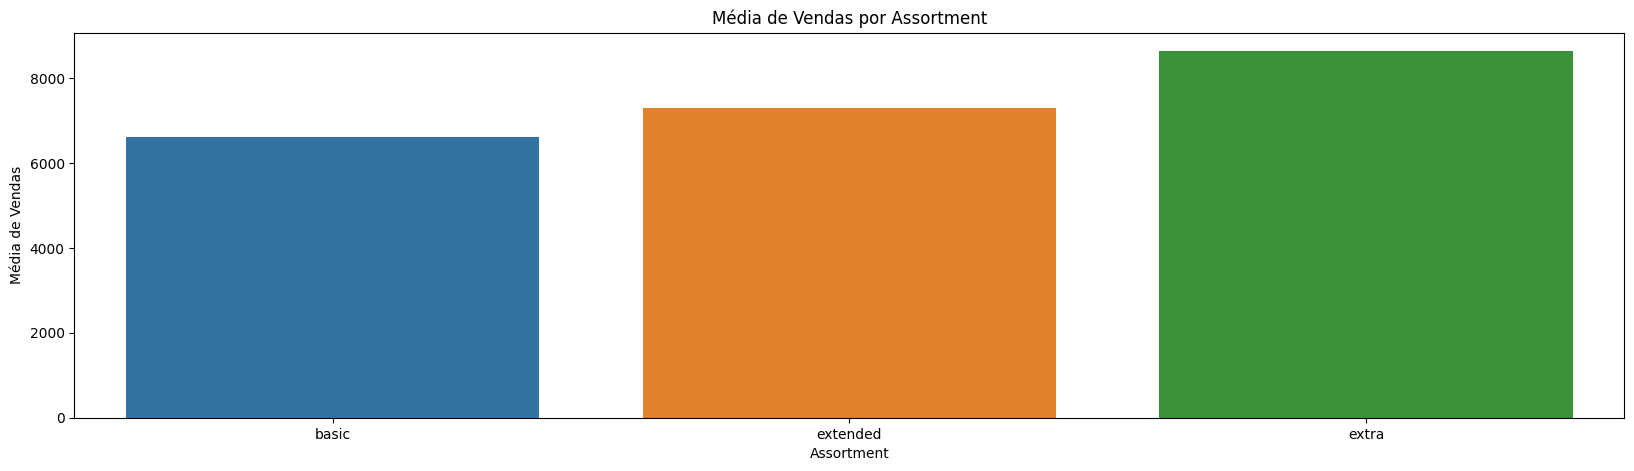

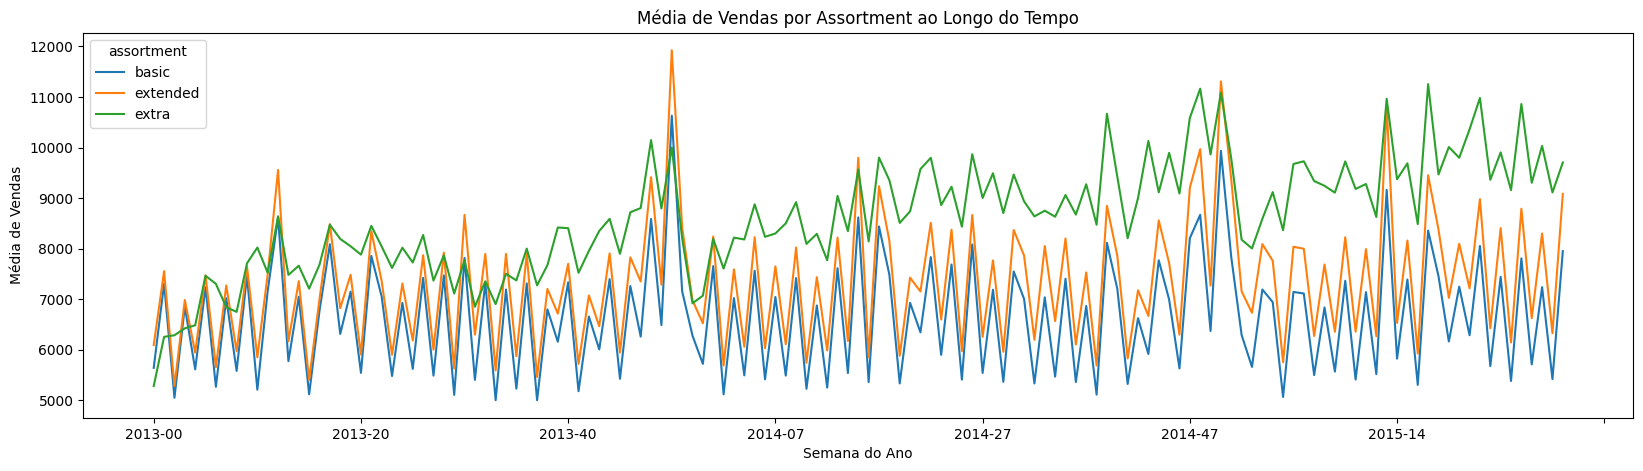

In [27]:
# define figure
plt.figure(figsize=(20,5))


# first plot
df_aux = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data= df_aux)
plt.xlabel('Assortment')
plt.ylabel('Média de Vendas')
plt.title('Média de Vendas por Assortment')

# second plot
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(20,5))
plt.xlabel('Semana do Ano')
plt.ylabel('Média de Vendas')
plt.title('Média de Vendas por Assortment ao Longo do Tempo')











### ***H2.*** Lojas com competidores mais próximos deveriam vender em média menos.
***FALSO*** Lojas com competidores mais próximos vendem em média mais.


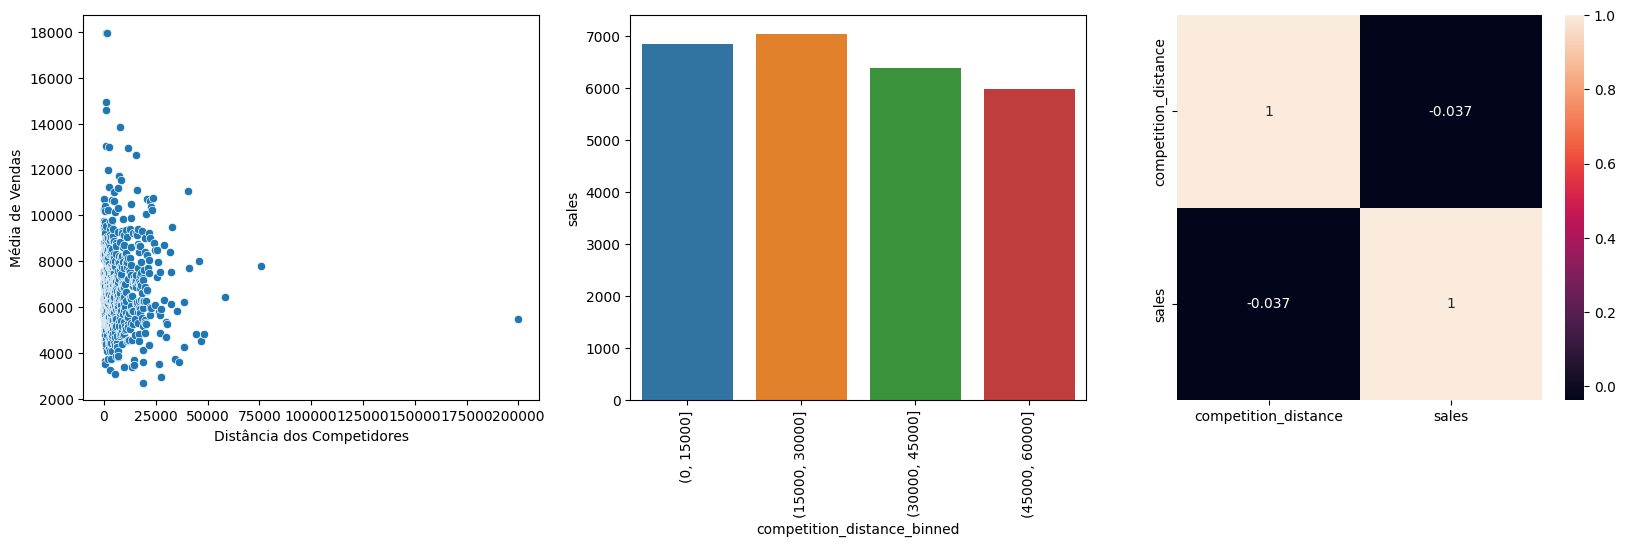

In [28]:
# new dataframe
aux1 = df4.loc[:, ['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
df_aux = aux1.copy()

# define figure
plt.figure(figsize=(20,5))

# first plot
plt.subplot(1, 3, 1)
sns.scatterplot(x= 'competition_distance', y='sales', data=aux1)
plt.xlabel('Distância dos Competidores')
plt.ylabel('Média de Vendas')


plt.subplot(1, 3, 2)
bins = list(np.arange(0, 60001, 15000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins, duplicates='drop' )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).mean().reset_index()

sns.barplot( x='competition_distance_binned', y='sales', data=aux2 )
plt.xticks( rotation=90 )

plt.subplot(1, 3, 3)
x = sns.heatmap(df_aux.corr(method='pearson'), annot= True)



### ***H3.*** Lojas com competidores mais recentes deveriam vender em média menos.
***FALSO*** Lojas com competidores mais recentes vendem em média mais.


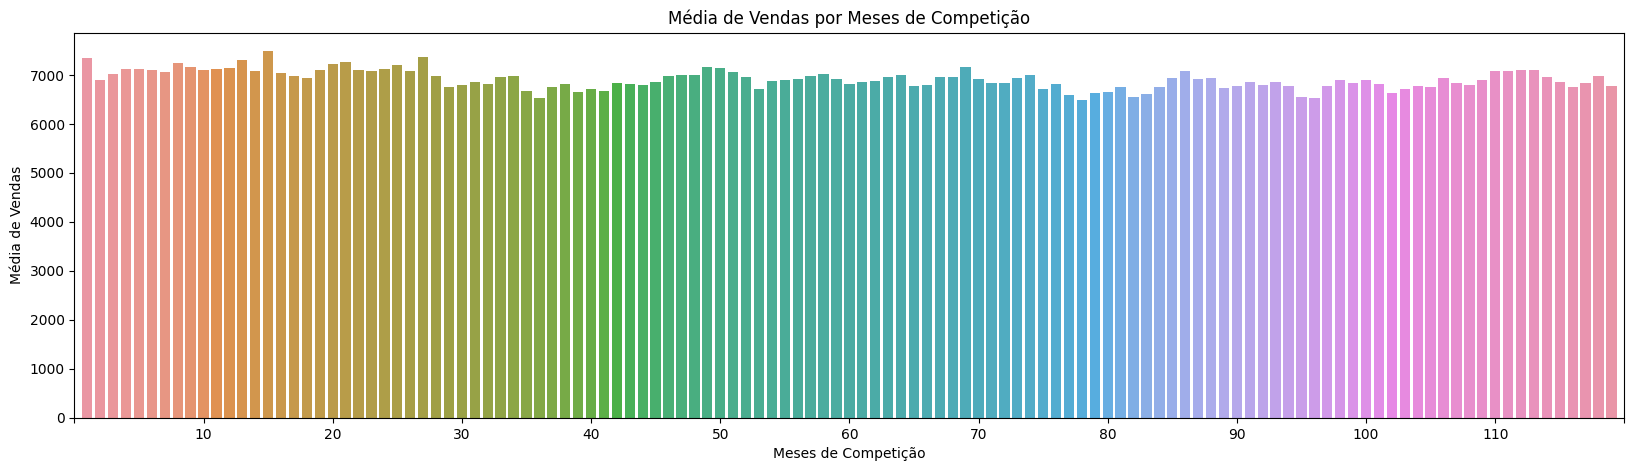

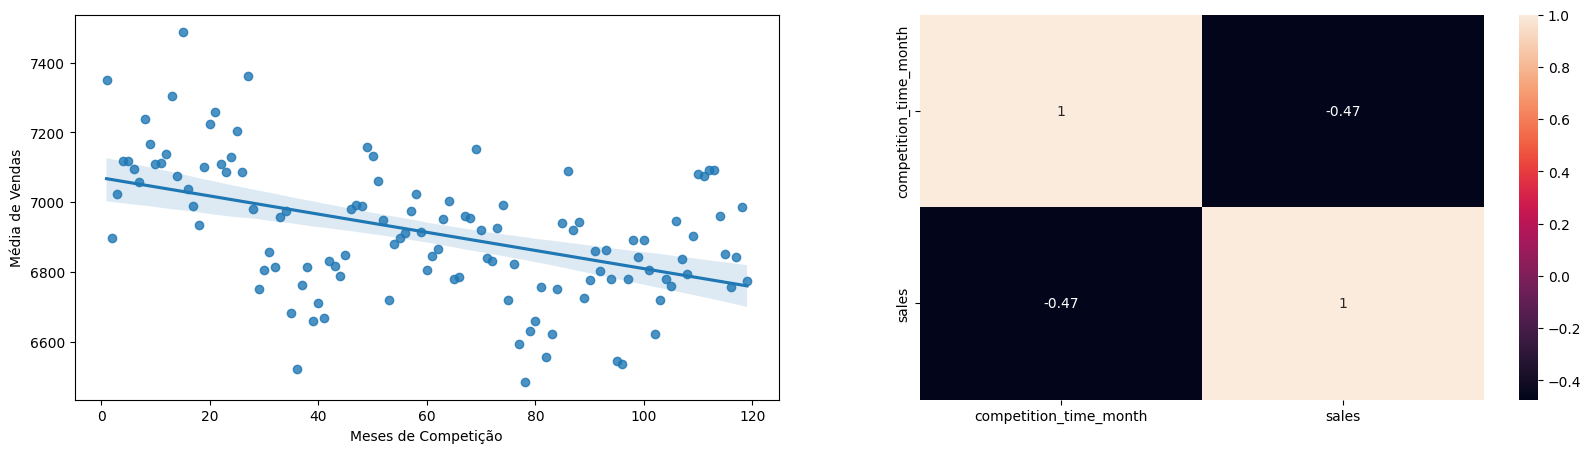

In [29]:
filtro_linhas = ( df4['competition_time_month'] < 120 ) & (df4['competition_time_month'] > 0 ) 
aux1 = df4.loc[filtro_linhas,['competition_time_month', 'sales']].groupby('competition_time_month' ).mean().reset_index()

# Primeiro grafico
plt.figure(figsize=(20,5))

sns.barplot( x='competition_time_month', y='sales', data=aux1 );
plt.xlabel('Meses de Competição')
plt.ylabel('Média de Vendas')
plt.title('Média de Vendas por Meses de Competição')
plt.xticks( range(-1, 120, 10) );

plt.figure(figsize=(20,5))
plt.subplot( 1, 2, 1 )
sns.regplot( x='competition_time_month', y='sales', data=aux1 );
plt.xlabel('Meses de Competição')
plt.ylabel('Média de Vendas')



plt.subplot(1, 2, 2)
x = sns.heatmap(aux1.corr(method='pearson'), annot= True);


### ***H4.*** Lojas que aderiram a estratégia promo2 há mais tempo deveriam vender em média menos.
***FALSO*** Lojas que aderiram a estratégia promo2 há mais tempo vendem mais.

<Axes: >

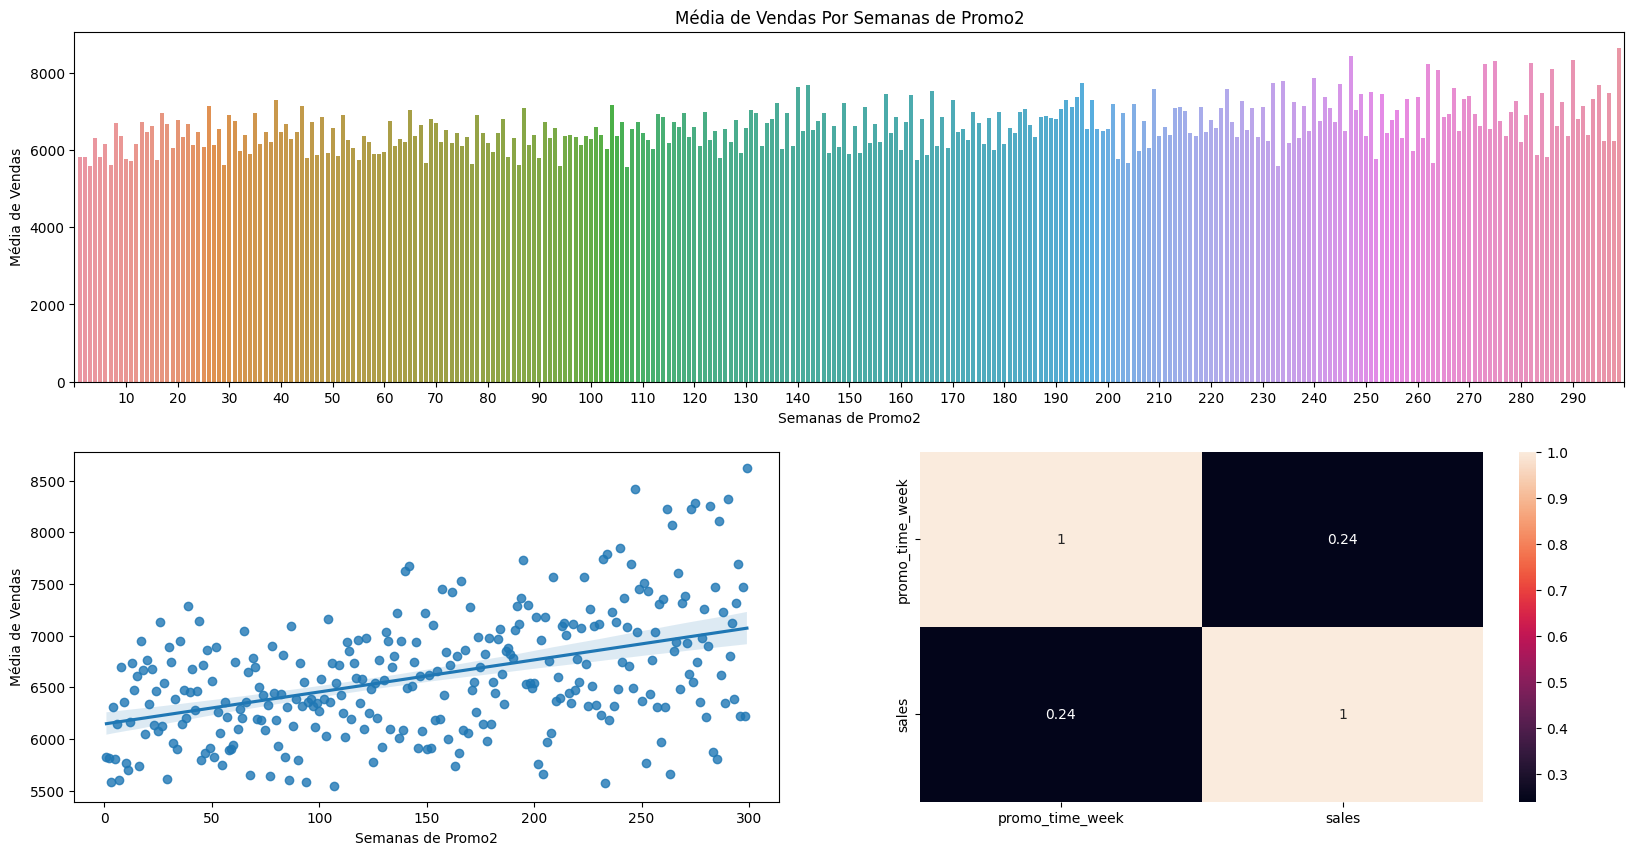

In [30]:
# new dataframe
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').mean().reset_index()
# define figure
plt.figure(figsize=(20,10))

# first plot
grid = plt.GridSpec( 2, 2 )
plt.subplot( grid[0,:] )

aux2 = aux1[(aux1['promo_time_week'] > 0) & (aux1['promo_time_week'] < 300)] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 )
plt.xticks(range(-1, 300, 10))
plt.xlabel('Semanas de Promo2')
plt.ylabel('Média de Vendas')
plt.title('Média de Vendas Por Semanas de Promo2')

# second plot
plt.subplot( grid[1,0] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 )
plt.xlabel('Semanas de Promo2')
plt.ylabel('Média de Vendas')

# third plot
plt.subplot( grid[1,1] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )


### ***H5***  Lojas com mais promoções consecutivas deveriam vender em média mais.
***FALSO*** Lojas que tem a promo2 ativa vendem em média menos.

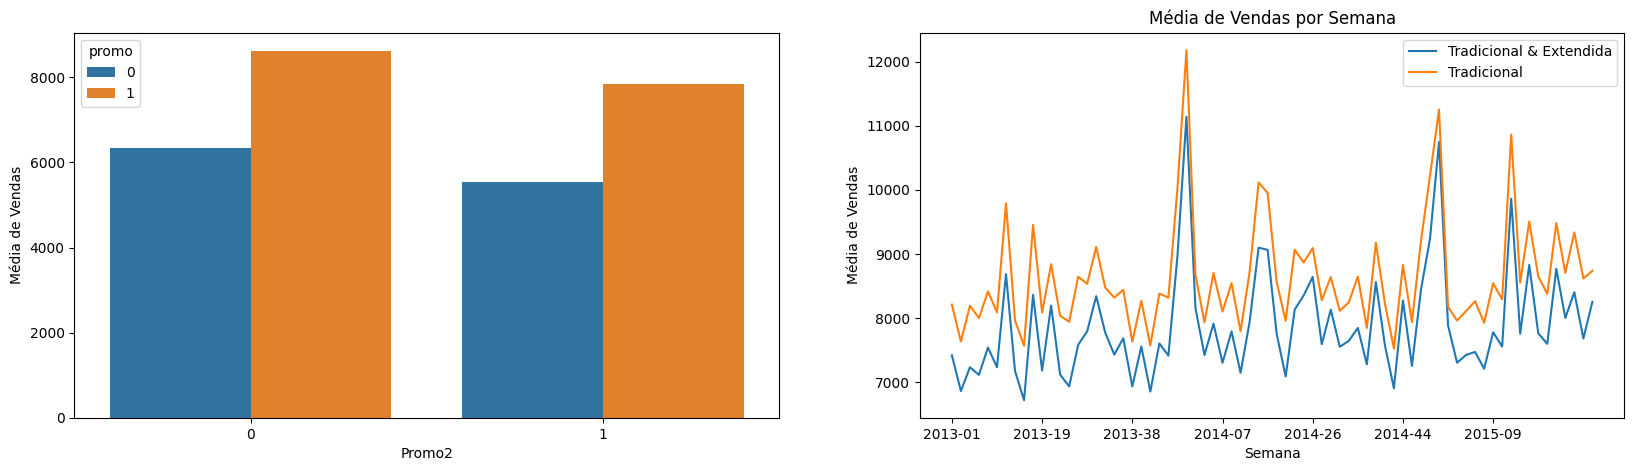

In [31]:
# define figure
plt.figure(figsize=(20, 5))
# first plot
plt.subplot(1, 2, 1)
aux = df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).mean().reset_index()
sns.barplot(x= 'promo2', y='sales', hue='promo', data= aux)

plt.xlabel('Promo2')
plt.ylabel('Média de Vendas')

# second plot
plt.subplot(1, 2, 2)
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()

plt.plot(aux1['year_week'], aux1['sales'], label='Tradicional & Extendida')
plt.plot(aux2['year_week'], aux2['sales'], label='Tradicional')
plt.xlabel('Semana')
plt.ylabel('Média de Vendas')
plt.title('Média de Vendas por Semana')
plt.xticks(range(0, 70, 10))
plt.legend()






### ***H6***  Lojas abertas durante o feriado de Natal deveriam vender em média mais.
***VERDADEIRO*** Lojas abertas durante o feriado de Natal vendem em média mais.

Text(0, 0.5, 'Média de Vendas')

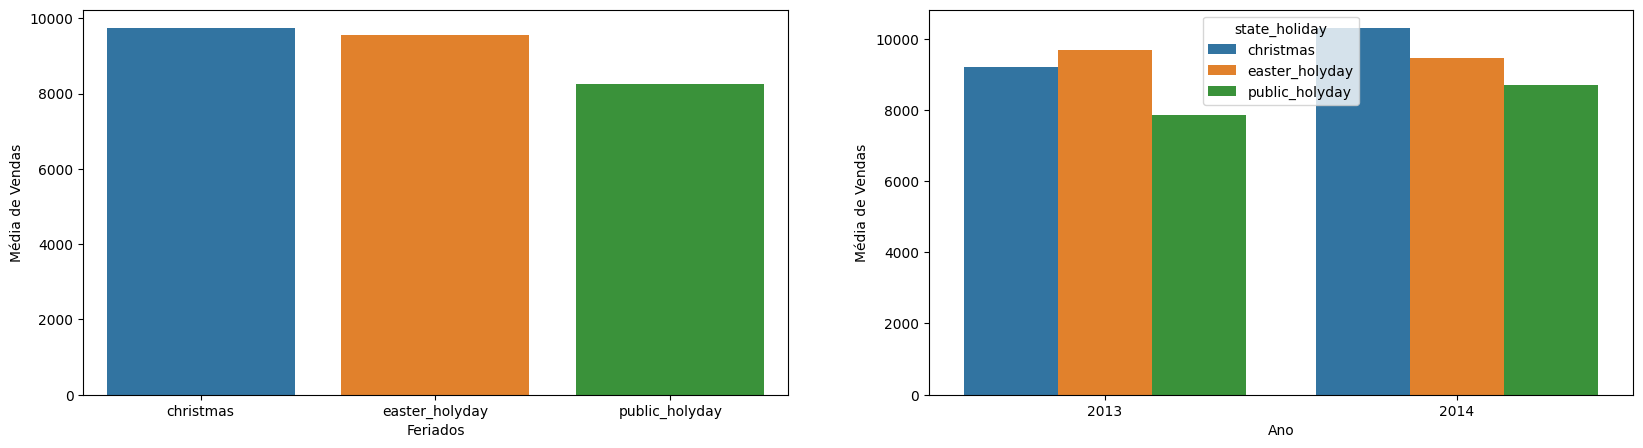

In [32]:
# new dataframe
aux = df4.loc[(df4['year'] < 2015) & (df4['state_holiday'] != 'regular_day'), :]

# define figure
plt.figure(figsize=(20,5))

# first plot
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 )
plt.xlabel('Feriados')
plt.ylabel('Média de Vendas')


# second plot
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 )
plt.xlabel('Ano')
plt.ylabel('Média de Vendas')


### ***H7*** Lojas deveriam vender mais ao longo dos anos
***FALSO*** Ao longo dos anos as lojas estão vendendo menos.

<Axes: >

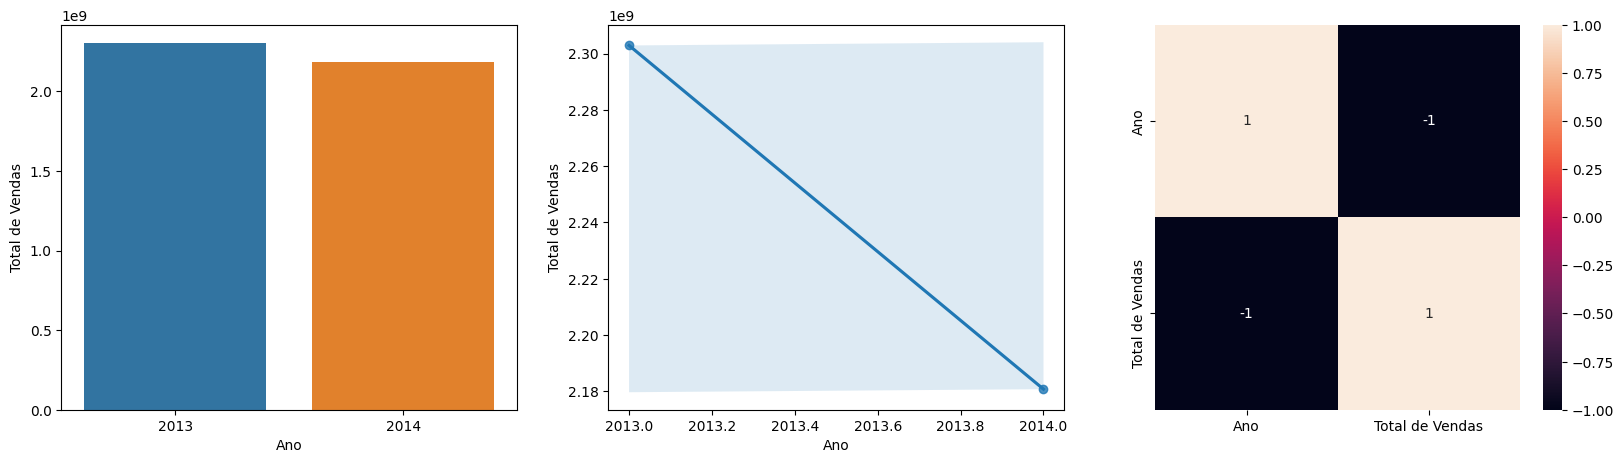

In [33]:
# new dataframe
aux1 = df4.loc[df4['year'] < 2015, ['year', 'sales']].groupby('year').sum().reset_index()
aux1.columns=['Ano', 'Total de Vendas']

# define figure
plt.figure(figsize=(20,5))

# first plot
plt.subplot(1, 3, 1)
sns.barplot(x='Ano', y='Total de Vendas', data=aux1)

# second plot
plt.subplot(1, 3, 2)
sns.regplot(x='Ano', y='Total de Vendas', data=aux1)

# third plot
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True)

### ***H8*** Lojas deveriam vender mais no segundo semestre do ano
***VERDADEIRO*** As lojas vendem mais no segundo semestre do ano.

<Axes: >

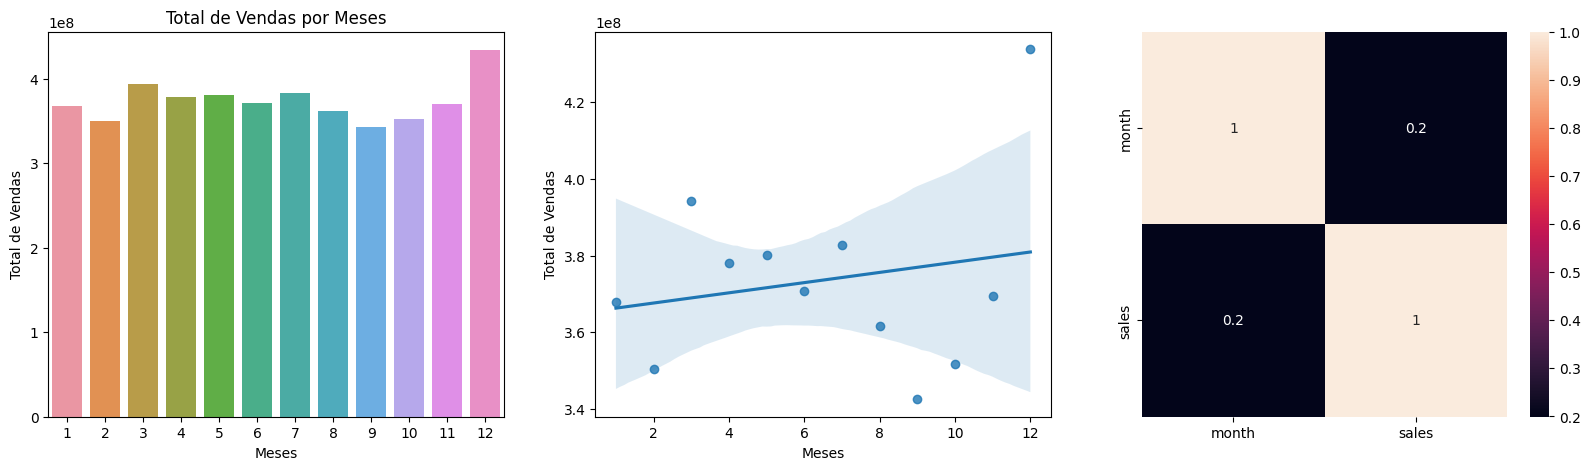

In [34]:
# new dataframe
aux1 = df4.loc[df4['year'] < 2015, ['month', 'sales']].groupby('month').sum().reset_index()


# define figure
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)
plt.xlabel('Meses')
plt.ylabel('Total de Vendas')
plt.title('Total de Vendas por Meses')


plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)
plt.xlabel('Meses')
plt.ylabel('Total de Vendas')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True)







### ***H9*** Lojas deveriam vender em média menos depois do dia 10 de cada mês
***VERDADEIRO*** Lojas vendem em média menos depois do dia 10 de cada mês.

Text(0.5, 1.0, 'Vendas em Média antes e depois do dia 10')

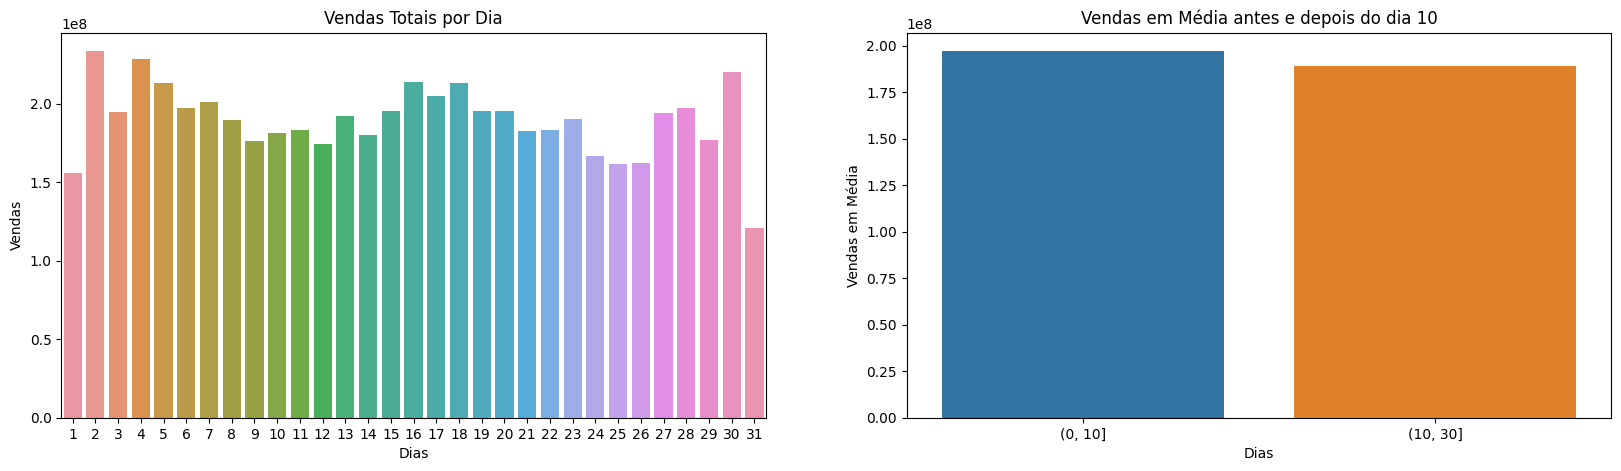

In [35]:
# new dataframe
aux1 = df4.loc[:,['day', 'sales']].groupby('day').sum().reset_index()
bins = list(np.arange(0, 11, 10)) + list(np.arange(10, 31, 20))
aux1['day_binned'] = pd.cut( aux1['day'], bins=bins, duplicates='drop' )
aux2 = aux1[['day_binned', 'sales']].groupby('day_binned').mean().reset_index()

# define figure
plt.figure(figsize=(20, 5))


# first plot
plt.subplot (1, 2, 1)
sns.barplot(x='day', y='sales', data= aux1)
plt.xlabel('Dias')
plt.ylabel('Vendas')
plt.title('Vendas Totais por Dia')


# second plot
plt.subplot (1, 2, 2)
sns.barplot( x='day_binned', y='sales', data=aux2 );
plt.xlabel('Dias')
plt.ylabel('Vendas em Média')
plt.title('Vendas em Média antes e depois do dia 10')





### ***H10*** Lojas deveriam vender em média menos aos finais de semana.
***VERDADEIRO*** Lojas vendem em média menos aos finais de semana.

Text(0, 0.5, 'Média de Vendas')

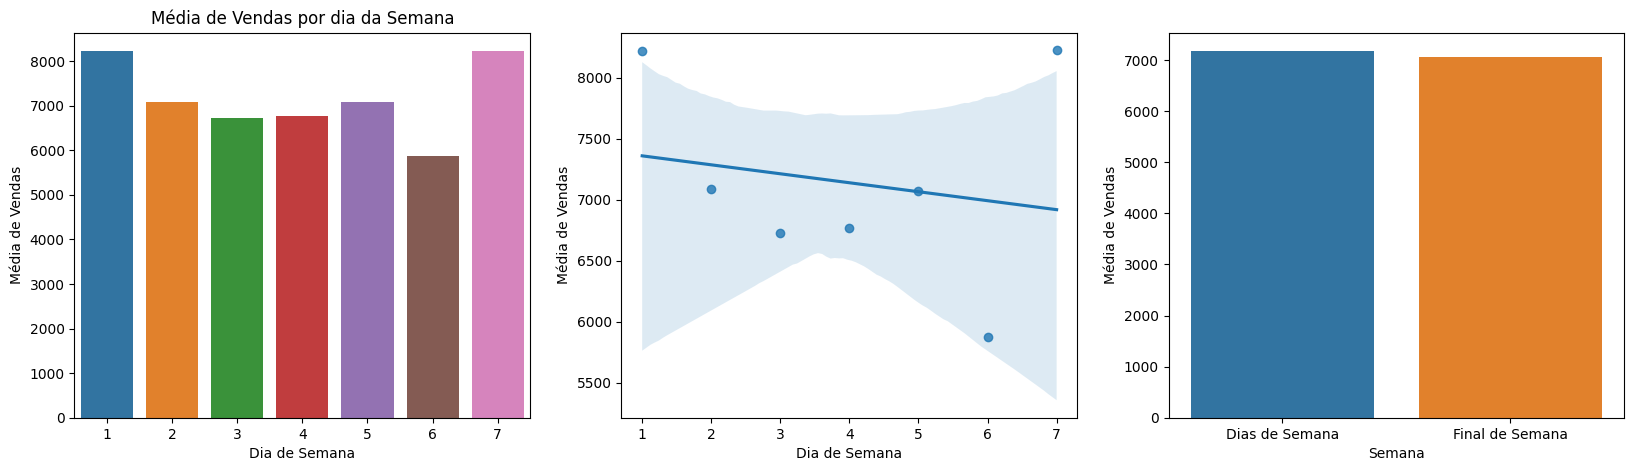

In [36]:
# new dataframe
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).mean().reset_index()
aux1['week_day_or_end'] = aux1['day_of_week'].apply( lambda x: 'Dias de Semana' if x <= 5 else 'Final de Semana')

# define figure
plt.figure(figsize=(20,5))

# first plot
plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );
plt.xlabel('Dia de Semana')
plt.ylabel('Média de Vendas')
plt.title('Média de Vendas por dia da Semana')

# second plot
plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );
plt.xlabel('Dia de Semana')
plt.ylabel('Média de Vendas')

# third plot
aux2 = aux1[['week_day_or_end', 'sales']].groupby( 'week_day_or_end' ).mean().reset_index()
plt.subplot( 1, 3, 3 )
sns.barplot( x='week_day_or_end', y='sales', data=aux2 )
plt.xlabel('Semana')
plt.ylabel('Média de Vendas')


### ***H11*** Lojas deveriam vender em média menos durante os feriados escolares.
***FALSO*** As lojas vendem em média mais durante os feriados escolares.


Text(0, 0.5, 'Média de Vendas')

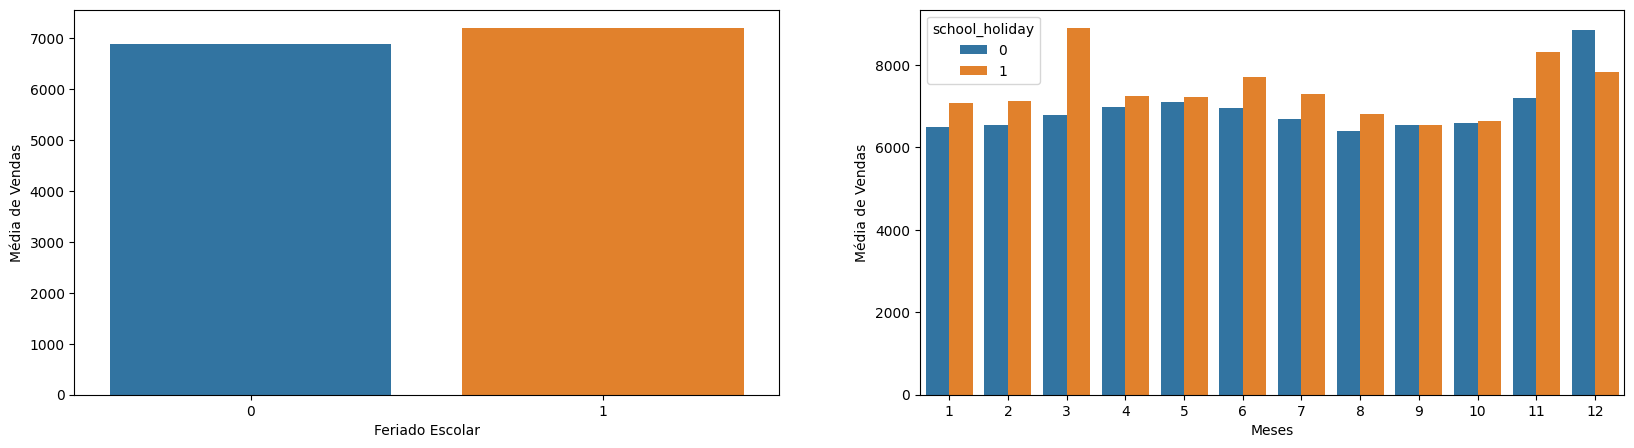

In [37]:
# new dataframe
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()

# define figure
plt.figure(figsize=(20,5))

# first plot
plt.subplot( 1, 2, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
plt.xlabel('Feriado Escolar')
plt.ylabel('Média de Vendas')


aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).mean().reset_index()
plt.subplot( 1, 2, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );
plt.xlabel('Meses')
plt.ylabel('Média de Vendas')


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

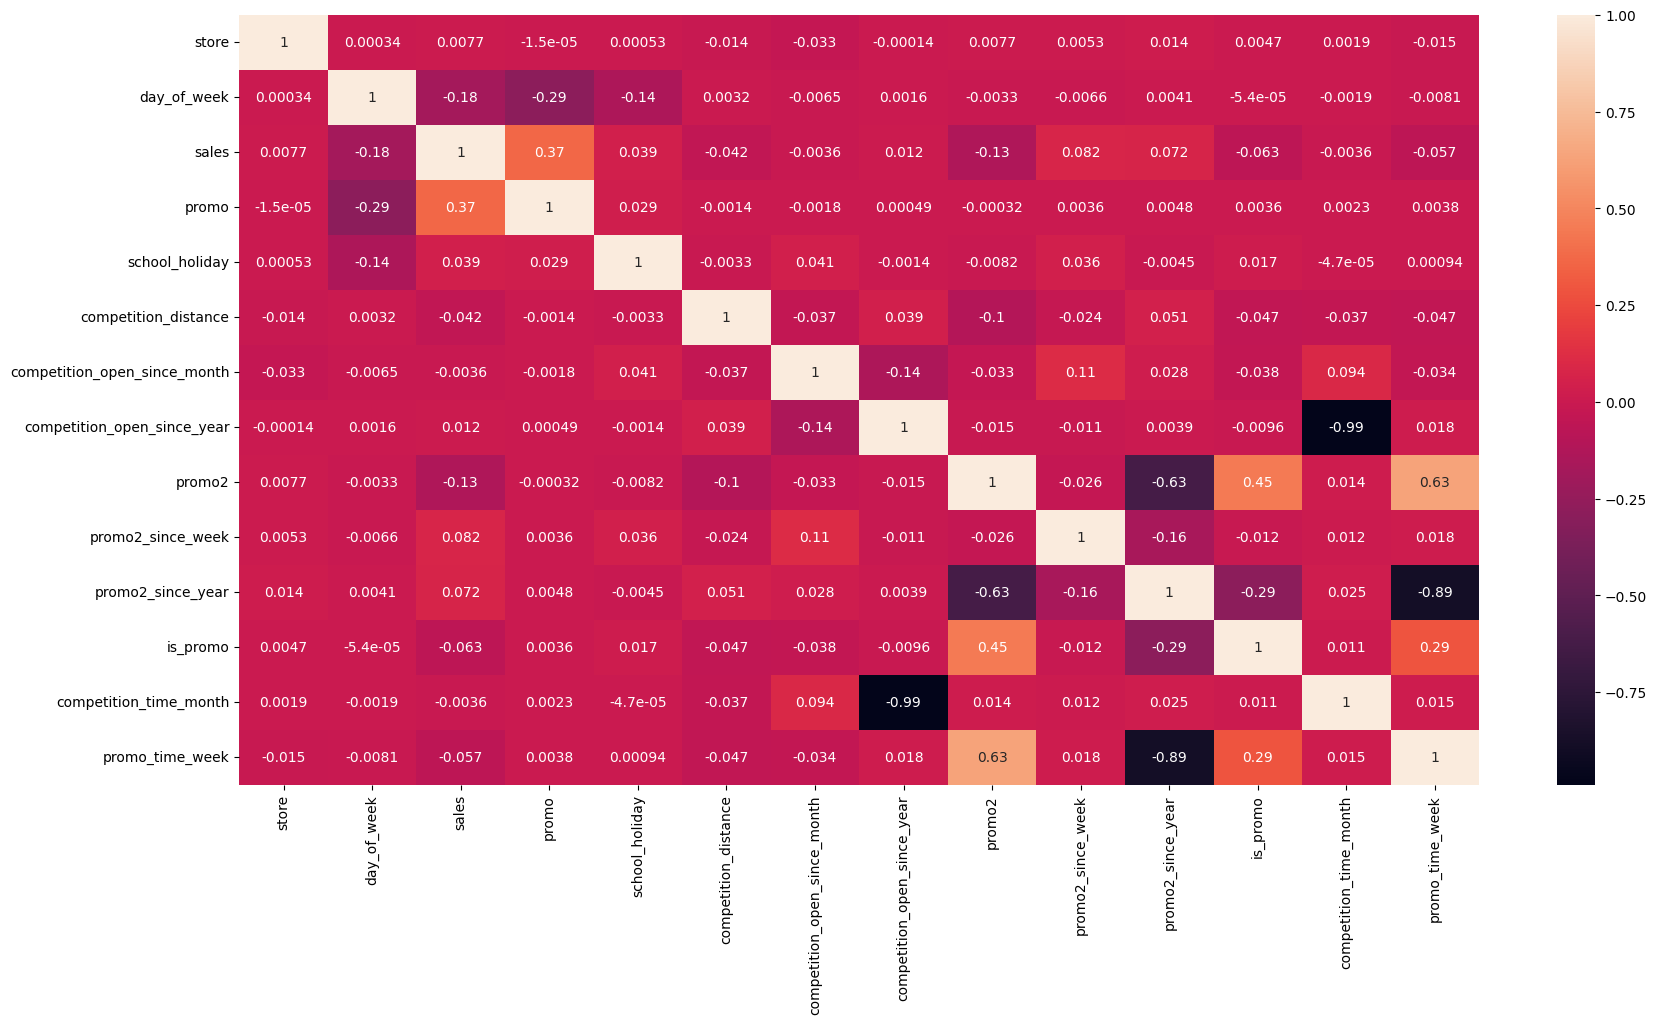

In [43]:
num_attributes1 = df4.select_dtypes( include=['int64', 'float64'] )
correlation = num_attributes1.corr( method='pearson' )
plt.figure(figsize=(20,10))
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

<Axes: >

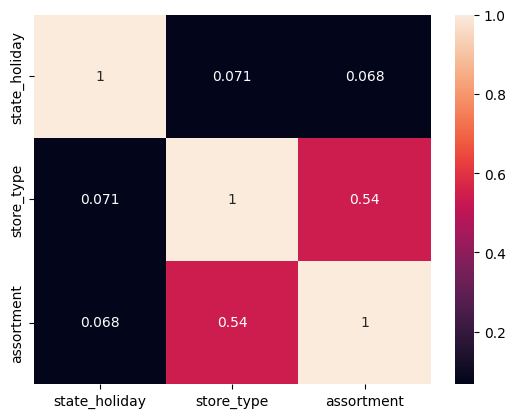

In [44]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

#  5.0. PASSO 05 - DATA PREPARATION

In [39]:
df5 = df4.copy()

## 5.1 Normalizacao

## 5.2 Rescaling

In [40]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

pickle.dump(rs, open('/home/tiagobarreto/DS/repos/DS_em_producao/parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('/home/tiagobarreto/DS/repos/DS_em_producao/parameter/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('/home/tiagobarreto/DS/repos/DS_em_producao/parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('/home/tiagobarreto/DS/repos/DS_em_producao/parameter/year_scaler.pkl', 'wb'))


## 5.3 Transformação

### 5.3.1 Encoding

In [41]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype= int)

# store_type - Label Encoding
le= LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('/home/tiagobarreto/DS/repos/DS_em_producao/parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,'extended': 2,'extra': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [42]:
df5['sales'] = np.log1p( df5['sales'])

### 5.3.3 Nature Transformation

In [43]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52 ) ) )

#  6.0. PASSO 06 - SELECAO DE ATRIBUTOS

In [44]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [45]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [46]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 Boruta as Feature Selector

In [53]:
# training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis= 1).values
#y_train_n = y_train.values.ravel()

# define random forest
#rf = RandomForestRegressor(n_jobs = -1)

# define boruta
#boruta = BorutaPy(rf, n_estimators ='auto', verbose=2, random_state = 42).fit(X_train_n, y_train_n)


In [54]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date','sales'], axis= 1)
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#Cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [47]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']

# columns to add
feat_to_add = ['date','sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

#  7.0. PASSO 07 - MACHINE LEARNING

In [48]:
df7 = df6.copy()

##  7.1. Average Model

In [49]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]


In [58]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


##  7.2. Linear Regression Model

In [59]:
# model
lr = LinearRegression().fit(x_train, y_train)

# predict
yhat_lr = lr.predict(x_test)
# performance
lr_result = ml_error("LinearRegression", np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,LinearRegression,1861.127229,0.291652,2662.291292


### 7.2. Linear Regression Model - Cross Validation

In [60]:
lr_result_cv = ts_cross_validation( x_training, lr, 'Linear Regression', 5, verbose=False )
lr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2315.4 +/- 630.73,0.34 +/- 0.06,3222.41 +/- 694.42


##  7.3. Linear Regression Regularized Model

In [61]:
# model
lrr = Lasso().fit(x_train, y_train)

# predict
yhat_lrr = lrr.predict(x_test)
# performance
lrr_result = ml_error("Lasso", np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,2198.584167,0.342759,3110.514747


### 7.3. Linear Regression Regularized Model - Cross Validation

In [62]:
lrr_result_cv = ts_cross_validation( x_training, lrr, 'Lasso', 5, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2248.0 +/- 80.6,0.37 +/- 0.01,3133.63 +/- 150.18


##  7.4. Random Forest Regressor Model

In [64]:
# # model
rf = RandomForestRegressor(random_state = 42).fit(x_train, y_train)

# predict
yhat_rf = rf.predict(x_test)
# performance
rf_result = ml_error("Random Forest Regressor", np.expm1(y_test), np.expm1(yhat_rf) )

In [75]:

# predict
yhat_rf = rf.predict(x_test)
# performance
rf_result = ml_error("Random Forest Regressor", np.expm1(y_test), np.expm1(yhat_rf) )

In [80]:
yhat_rgb

array([ 8.57842293,  8.78809198,  9.11576899, ...,  8.83293974,
       10.04083747,  9.08447309])

### 7.4. Random Forest Model - Cross Validation

In [65]:
rf_result_cv = ts_cross_validation( x_training, rf, 'Random Forest Regressor', 5, verbose=False )
rf_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,983.99 +/- 196.91,0.14 +/- 0.02,1569.12 +/- 361.45


##  7.5. XGBoost Regressor Model

In [67]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror').fit(x_train, y_train)

# # predict
# yhat_rgb = model_xgb.predict(x_test)
# # performance
# xgb_result = ml_error("XGBoost", np.expm1(y_test), np.expm1(yhat_rgb) )

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_

In [81]:
# predict
yhat_rgb = model_xgb.predict(x_test)
# performance
xgb_result = ml_error("XGBoost", np.expm1(y_test), np.expm1(yhat_rgb) )

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_

### 7.5. XGBoost Regressor Model - Cross Validation

In [68]:
xgb_result_cv = ts_cross_validation( x_training, model_xgb, 'XGBoost Regressor', 5, verbose=False )
xgb_result_cv

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1133.19 +/- 177.0,0.17 +/- 0.02,1645.36 +/- 285.61


## 7.6. Compare Model's Performance

### 7.6.1 Single Performance

In [82]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,667.180470,0.098737,994.813477
0,XGBoost,865.823609,0.129090,1242.470752
0,Average Model,1354.800353,0.206400,1835.135542
0,LinearRegression,1861.127229,0.291652,2662.291292
0,Lasso,2198.584167,0.342759,3110.514747


### 7.6.2  Real Performance - Cross Validation



In [69]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,983.99 +/- 196.91,0.14 +/- 0.02,1569.12 +/- 361.45
0,XGBoost Regressor,1133.19 +/- 177.0,0.17 +/- 0.02,1645.36 +/- 285.61
0,Lasso,2248.0 +/- 80.6,0.37 +/- 0.01,3133.63 +/- 150.18
0,Linear Regression,2315.4 +/- 630.73,0.34 +/- 0.06,3222.41 +/- 694.42


In [74]:
pickle.load(open( '/home/tiagobarreto/DS/repos/DS_em_producao/machine_learning/modelling_result.pkl', 'rb'))

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2315.4 +/- 630.73,0.34 +/- 0.06,3222.41 +/- 694.42
0,Lasso,2248.0 +/- 80.6,0.37 +/- 0.01,3133.63 +/- 150.18
0,Random Forest Regressor,983.99 +/- 196.91,0.14 +/- 0.02,1569.12 +/- 361.45
0,XGBoost Regressor,1133.19 +/- 177.0,0.17 +/- 0.02,1645.36 +/- 285.61


# 8.0 Passo 08 - Hyperparameter Fine Tunning

## 8.1 Bayesian Search

In [228]:

# search_space = {'max_depth': (5, 15),   
#     'learning_rate': (0.03, 0.15, 'log-uniform'),
#     'subsample': (0.3, 0.7, 'uniform'),
#     'n_estimators': (300, 1000)
# }

# tscv = TimeSeriesSplit(n_splits=5)  

# bayes_cv = BayesSearchCV(
#     xgb.XGBRegressor(),
#     search_space,
#     cv=tscv,  # Use o TimeSeriesSplit como estratégia de validação cruzada
#     n_iter=50,
#     random_state=42, 
#     scoring= 'neg_root_mean_squared_error'
# )


# xtraining = x_train
# ytraining = x_training['sales']



    
# model_bay = bayes_cv.fit(xtraining, ytraining)

# best_params = model_bay.best_params_



## 8.2 Final Model

In [50]:
# learning_rate: 0.0509,max_depth: 10,n_estimators: 861,subsample: 0.5051
xgb_tuned = xgb.XGBRegressor(learning_rate= 0.06 , max_depth= 9, n_estimators= 375 , subsample= 0.5051).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = xgb_tuned.predict( x_test )
# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

xgb_result_tuned




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,708.999657,0.102743,1037.787015


# 9.0 Passo 09 - Tradução e Interpretação do Erro

In [51]:
df9 = X_test[cols_selected_boruta_full]

# rescale

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

/tmp/ipykernel_11305/2079476676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
/tmp/ipykernel_11305/2079476676.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


## 9.1 Business Performance

In [52]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions']) ).reset_index().rename(columns= {0: 'MAE'})

df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions']) ).reset_index().rename(columns= {0: 'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on= 'store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

df92['times'] = df9[['sales', 'store']].groupby('store').apply(lambda x: x['store'].count())

df92['times'] = df92['times'].apply(lambda x: 37 if math.isnan(x) else x)  

# Scenario
df92['worst_scenario'] = df92['predictions'] - (df92['MAE'] * df92['times'])
df92['best_scenario'] = df92['predictions'] + (df92['MAE'] * df92['times'])

# order columns
df92 = df92.drop('times', axis = 1)
df92 = df92[['store', 'predictions', 'worst_scenario','best_scenario','MAE', 'MAPE']]




/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/ds_em_producao/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='store', ylabel='MAPE'>

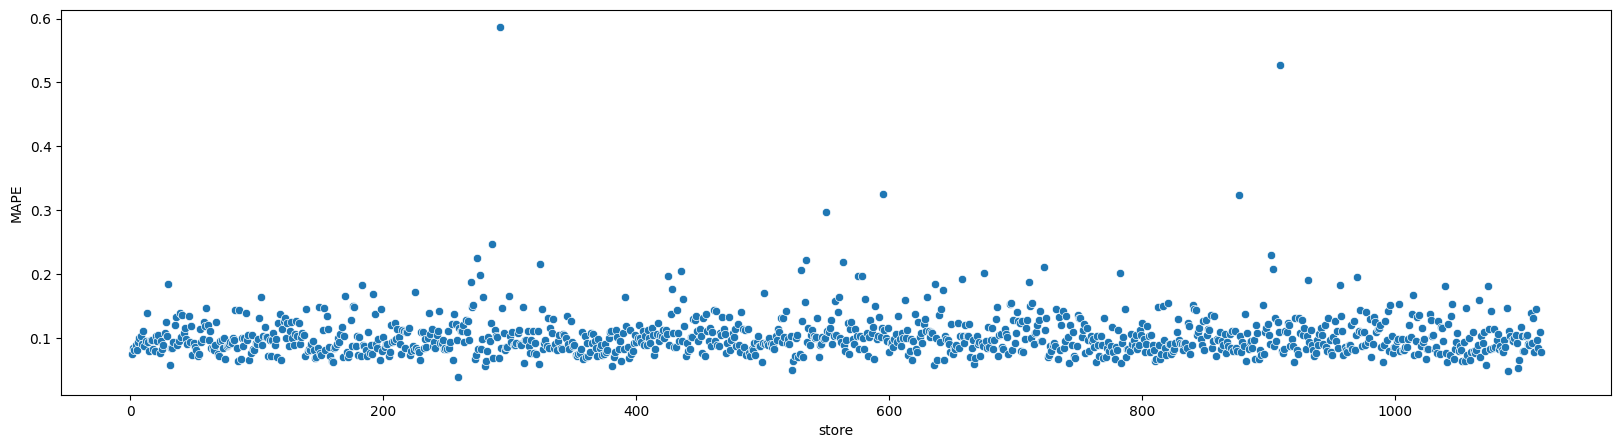

In [37]:
plt.figure(figsize=(20, 5))
sns.scatterplot(x='store', y='MAPE', data = df92)

<Axes: xlabel='error_binned', ylabel='store'>

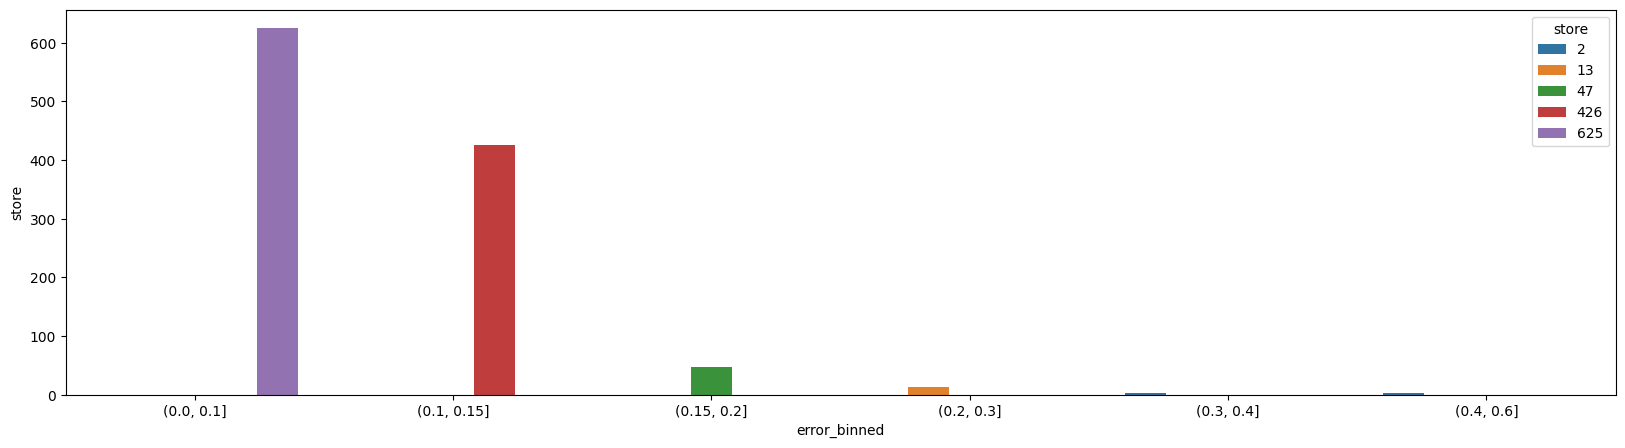

In [53]:
plt.figure(figsize=(20,5))
bins = [0, 0.10, 0.15, 0.20, 0.30, 0.40, 0.60]
df92['error_binned'] = pd.cut( df92['MAPE'], bins=bins, duplicates='drop' )
aux2 = df92[['error_binned', 'store']].groupby('error_binned').count().reset_index()
sns.barplot(x= aux2['error_binned'], y=aux2['store'], hue= aux2['store'])


## 9.2 Total Performance

In [54]:
df93 = df92[['predictions', 'worst_scenario','best_scenario']].apply( lambda x: np.sum(x), axis= 0).reset_index().rename(columns={'index': 'Scenarios', 0: 'Values'})
df93['Values'] = df93['Values'].apply(lambda x: f"{x:,.2f}")
df93

,Scenarios,Values
0,predictions,"282,697,408.00"
1,worst_scenario,"253,204,264.64"
2,best_scenario,"312,190,531.69"


## 9.3 Machine Learning Perfomance

In [60]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales'] 

/tmp/ipykernel_11305/3441296601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
/tmp/ipykernel_11305/3441296601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


/tmp/ipykernel_11305/2738539585.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df9['error'])


<Axes: xlabel='predictions', ylabel='error'>

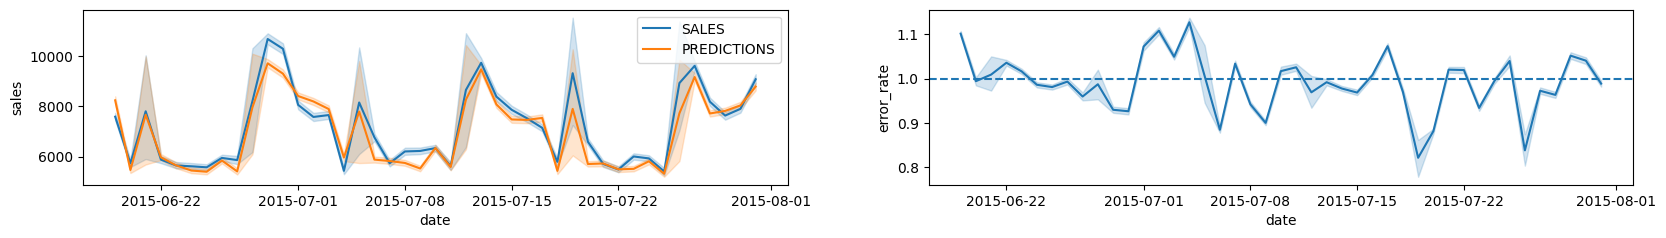

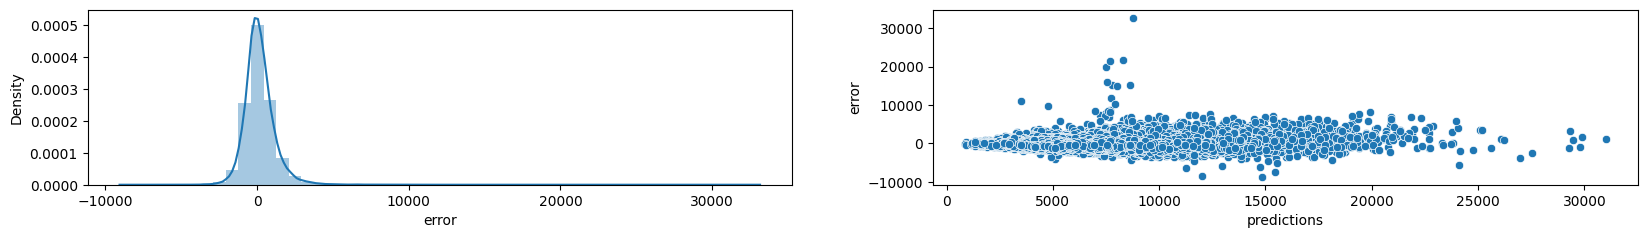

In [63]:
plt.figure(figsize=(20, 5))
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data= df9,label= 'SALES')
sns.lineplot(x='date', y='predictions', data= df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data= df9)
plt.axhline(1, linestyle='--')

plt.figure(figsize=(20, 5))
plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x = df9['predictions'], y= df9['error'] )


# 10.0 Passo 10 - Deploy Model to Production

## 10.1 Rossmann Class

In [ ]:
import pickle
import inflection
import datetime
import math
import numpy as np
import pandas as pd


class Rossmann (object):
       def __init__(self):
              self.competition_distance_scaler   = pickle.load(open('parameter/competition_distance_scaler.pkl', 'rb'))
              self.competition_time_month_scaler = pickle.load(open('parameter/competition_time_month_scaler.pkl', 'rb'))
              self.promo_time_week_scaler        = pickle.load(open('parameter/promo_time_week_scaler.pkl', 'rb'))
              self.year_scaler                   = pickle.load(open('parameter/year_scaler.pkl', 'rb'))             
              self.store_type_scaler             = pickle.load(open('parameter/store_type_scaler.pkl', 'rb'))


       def data_cleaning(self, df1):

              ## 1.1. Rename Columns
              cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

              snakecase = lambda x: inflection.underscore(x)

              cols_new = list(map(snakecase, cols_old))

              # rename
              df1.columns = cols_new

              ## 1.3. Data Types
              df1['date'] = pd.to_datetime(df1['date'])

              ## 1.5. Fillout NA

              #competition_distance  
              df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)  

              #competition_open_since_month  
              df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

              #competition_open_since_year 
              df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

              #promo2_since_week   
              df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

              #promo2_since_year     
              df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

              #promo_interval 
              month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

              df1['promo_interval'].fillna(0, inplace= True)

              df1['month_map'] = df1['date'].dt.month.map(month_map)

              df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

              ## 1.6. Change Data Types

              # competiton
              df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
              df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

              # promo2
              df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
              df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

              return df1
       
       def feature_engineering(self, df2):

              # year 
              df2['year'] = df2['date'].dt.year

              # month
              df2['month'] = df2['date'].dt.month

              # day
              df2['day'] = df2['date'].dt.day

              # week of year
              df2['week_of_year'] = df2['date'].dt.isocalendar().week

              # year week
              df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

              # competition since
              df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis = 1)

              df2['competition_time_month'] = ( (df2['date'] - df2['competition_since'] )/30).apply(lambda x: x.days).astype(int)

              # promo since

              df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

              df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

              df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

              # assortment
              df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

              # state holiday
              df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holyday' if x=='a' else 'easter_holyday' if x=='b' else 'christmas' if x == 'c' else 'regular_day')

              # 3.0 Passo 03 - Filtragem de Variáveis

              ## 3.1 Filtragem das Linhas
              df2 = df2[df2['open'] != 0]

              ## 3.2 Seleção das Colunas
              cols_drop = ['open', 'promo_interval', 'month_map']
              df2 = df2.drop(cols_drop, axis = 1)

              return df2
       
       def data_preparation(self, df5):

              ## 5.2 Rescaling

              # competition_distance
              df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
              
              # competition_time_month
              df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

              # promo_time_week
              df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
       
              # year
              df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
              

              ## 5.3 Transformação

              ### 5.3.1 Encoding
              
              # store_type - Label Encoding
             
              df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
             

              # assortment - Ordinal Encoding
              assortment_dict = {'basic': 1,'extended': 2,'extra': 3}
              df5['assortment'] = df5['assortment'].map(assortment_dict)

              ### 5.3.3 Nature Transformation

              # month
              df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 ) ) )
              df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 ) ) )

              # day
              df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 ) ) )
              df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 ) ) )

              # day of week
              df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7 ) ) )
              df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7 ) ) )

              # week of year
              df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52 ) ) )
              df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52 ) ) )

              cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                            'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                            'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']

              return df5[cols_selected]
       
       def get_prediction(self, model, original_data, test_data):
              # prediction
              pred = model.predict( test_data )

              # join pred into the original data
              original_data['prediction'] = np.expm1(pred)

              # Arredondar os valores para duas casas decimais
              original_data['prediction'] = original_data['prediction'].round(2)

              # Converter os valores arredondados para inteiros
              original_data['prediction'] = original_data['prediction'].astype(int)

              original_data1 = original_data[['store','prediction']].groupby('store').sum().reset_index()

              return original_data1.to_json(orient = 'records', date_format = 'iso')

## 10.2 API Handler

In [ ]:
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open('/home/tiagobarreto/DS/repos/DS_em_producao/model/model_rossman.pkl', 'rb'))

app = Flask(__name__)

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance(test_json, dict): # Unique example
            test_raw = pd.DataFrame(test_json, index=[0])

        else: # Multiple Examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys() )

        # Instantiate Rossmann Class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
    
    else:
        return Response('{}', status = 200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0' )

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.5:5000
Press CTRL+C to quit


## 10.3 API Tester

In [18]:
import requests
import json

# loading test dataset
df10 = pd.read_csv('/home/tiagobarreto/DS/repos/DS_em_producao/data/test.csv')

# merge test dataset + store
df_test  = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'] < 50]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)


# convert DataFrame to json
data = json.dumps(df_test.to_dict( orient='records' ) )

# API Call
url = 'http://localhost:5000/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post(url, data= data, headers = header)
print('Status Code {}'.format (r.status_code))

d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

Status Code 200


# 11.0 Conclusão

- O projeto fornece uma solução automatizada para a previsão de vendas das lojas da Rossmann, eliminando a necessidade de previsões manuais feitas por gerentes de loja.
- O modelo de previsão de vendas desenvolvido demonstrou um desempenho consistente na maioria das lojas, com um erro médio de aproximadamente 10%. No entanto, é importante observar que o desempenho pode variar entre as lojas. Portanto, em primeiro lugar, podemos utilizar como referência para o orçamento de reformas as mais de 600 lojas com erro inferior a 10%. Dependendo do desempenho atual do método utilizado para a previsão de vendas, podemos considerar a inclusão das previsões das lojas com erro até 15% ou 20%. No entanto, aquelas que apresentarem um erro superior a esse valor deveriam ser discutidas com o CFO, e não devemos considerar as previsões das lojas 292 e 909, que possuem erros superiores a 50%.
- Uma das principais descobertas foi que as lojas que realizam promoções consecutivas tendem a vender em média menos. Isso pode ser útil para o CFO ao tomar decisões sobre a alocação de recursos para promoções.
- Outra descoberta importante foi que as lojas com competidores mais próximos tendem a vender em média mais. Isso pode ser uma informação valiosa ao considerar a localização das lojas e a concorrência.

# 12.0 Próximos Passos

Se fosse continuar o trabalho nesse projeto, realizando um segundo ciclo do CRISP-DS, consideraria os seguintes passos para tentar criar um novo modelo para as lojas com baixo desempenho ou melhorar o desempenho geral do modelo atual, sem outliers com grandes erros:
- Conduzir uma análise aprofundada para identificar as particularidades das lojas com baixo desempenho que estão dificultando a precisão das previsões do modelo.
- Coletar mais Dados.
- Efetuar a criação de novas variáveis a partir do conjunto de dados já existente.
- Experimentar diferentes modelos de Machine Learning.
- Formulação de novas hipóteses para gerar novos insights para o negócio.